# 02. Descriptive Statistics

This notebook performs basic descriptive statistics and distribution analysis on the financial news dataset.

**Sections:**
1. **Headline Length Analysis** - Character and word count statistics, distributions, and outlier detection
2. **Articles Per Publisher** - Publisher activity counts, top publishers, and long-tail distribution
3. **Publication Date Trends** - Yearly, monthly, daily patterns, day of week analysis, and spike detection

**Dependencies:** 
- Run `01_Data_Loading_and_Setup.ipynb` first to create processed data


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path

# Add utils to path
sys.path.append('.')
from utils import setup_plotting_style, load_processed_data

# Setup plotting style
setup_plotting_style()

print("Libraries imported successfully!")


Plotting style configured
Libraries imported successfully!


In [2]:
# Load processed data (if available) or load raw data
try:
    df = load_processed_data('../data/processed/df_processed.pkl')
    print(f"Loaded processed data: {df.shape}")
except FileNotFoundError:
    print("Processed data not found. Loading raw data...")
    from utils import load_data, preprocess_data
    df = load_data('../data/raw_analyst_ratings.csv')
    df = preprocess_data(df)
    print(f"Loaded and preprocessed data: {df.shape}")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


Loaded processed data from ../data/processed/df_processed.pkl
Shape: (1407328, 8)
Loaded processed data: (1407328, 8)

Dataset shape: (1407328, 8)
Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock', 'headline_length', 'headline_word_count']


## 1.1 Headline Length Analysis

**Objective:** Calculate basic statistics for headline text lengths and analyze distributions.

**Key Questions:**
- What is the typical headline length?
- Are there outliers (very short or very long headlines)?
- How does headline length vary by publisher or stock?


In [9]:
# Ensure headline metrics exist (if not already in processed data)
if 'headline_length' not in df.columns:
    df['headline_length'] = df['headline'].str.len()
if 'headline_word_count' not in df.columns:
    df['headline_word_count'] = df['headline'].str.split().str.len()

# Basic statistics
print("="*80)
print("HEADLINE LENGTH STATISTICS")
print("="*80)
print("\nCharacter Length Statistics:")
print(df['headline_length'].describe())
print(f"\nSkewness: {df['headline_length'].skew():.2f}")
print(f"Kurtosis: {df['headline_length'].kurtosis():.2f}")

print("\n" + "="*80)
print("WORD COUNT STATISTICS")
print("="*80)
print("\nWord Count Statistics:")
print(df['headline_word_count'].describe())
print(f"\nSkewness: {df['headline_word_count'].skew():.2f}")
print(f"Kurtosis: {df['headline_word_count'].kurtosis():.2f}")


HEADLINE LENGTH STATISTICS

Character Length Statistics:
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

Skewness: 2.10
Kurtosis: 6.48

WORD COUNT STATISTICS

Word Count Statistics:
count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: headline_word_count, dtype: float64

Skewness: 2.17
Kurtosis: 7.13


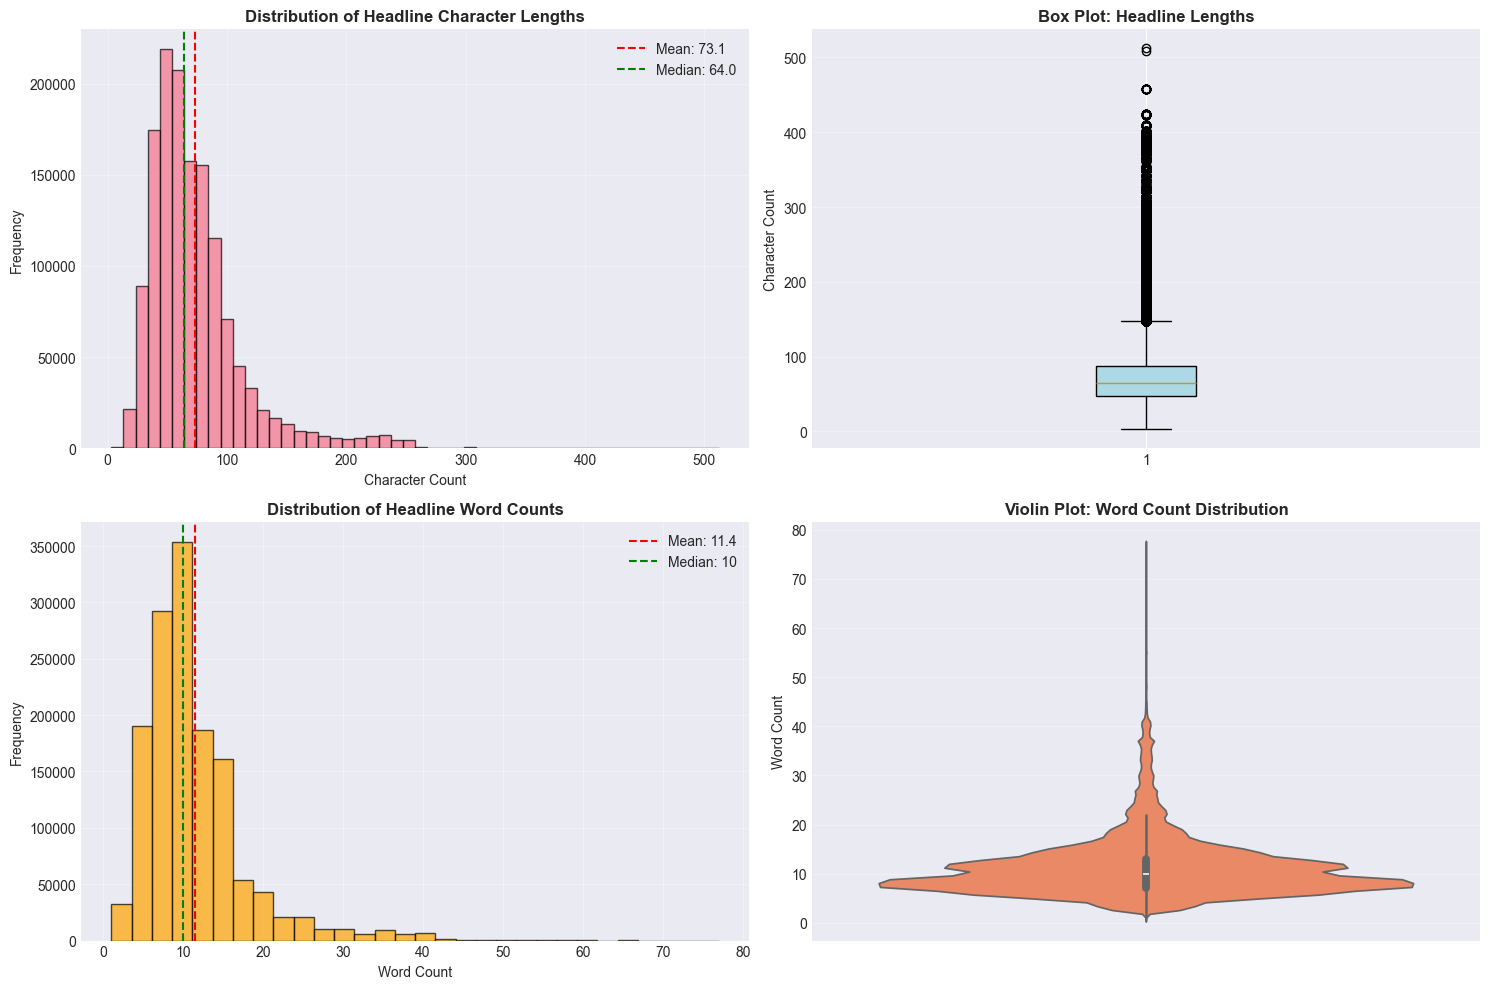

In [10]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of headline lengths
axes[0, 0].hist(df['headline_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['headline_length'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {df["headline_length"].mean():.1f}')
axes[0, 0].axvline(df['headline_length'].median(), color='green', linestyle='--', 
                    label=f'Median: {df["headline_length"].median():.1f}')
axes[0, 0].set_title('Distribution of Headline Character Lengths', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
bp = axes[0, 1].boxplot(df['headline_length'], vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[0, 1].set_title('Box Plot: Headline Lengths', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Character Count')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Word count distribution
axes[1, 0].hist(df['headline_word_count'], bins=30, edgecolor='black', color='orange', alpha=0.7)
axes[1, 0].axvline(df['headline_word_count'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["headline_word_count"].mean():.1f}')
axes[1, 0].axvline(df['headline_word_count'].median(), color='green', linestyle='--', 
                   label=f'Median: {df["headline_word_count"].median():.0f}')
axes[1, 0].set_title('Distribution of Headline Word Counts', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Violin plot for word count
sns.violinplot(y=df['headline_word_count'], ax=axes[1, 1], color='coral')
axes[1, 1].set_title('Violin Plot: Word Count Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Word Count')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('headline_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Outlier detection using IQR method
Q1_length = df['headline_length'].quantile(0.25)
Q3_length = df['headline_length'].quantile(0.75)
IQR_length = Q3_length - Q1_length
lower_bound = Q1_length - 1.5 * IQR_length
upper_bound = Q3_length + 1.5 * IQR_length

outliers_short = df[df['headline_length'] < lower_bound]
outliers_long = df[df['headline_length'] > upper_bound]

print("="*80)
print("OUTLIER DETECTION (IQR Method)")
print("="*80)
print(f"Lower bound: {lower_bound:.1f} characters")
print(f"Upper bound: {upper_bound:.1f} characters")
print(f"Short outliers (< {lower_bound:.1f} chars): {len(outliers_short):,} headlines ({len(outliers_short)/len(df)*100:.2f}%)")
print(f"Long outliers (> {upper_bound:.1f} chars): {len(outliers_long):,} headlines ({len(outliers_long)/len(df)*100:.2f}%)")

print(f"\nExtreme values:")
print(f"Shortest headline: {df['headline_length'].min()} characters")
print(f"Longest headline: {df['headline_length'].max()} characters")

# Show examples
print(f"\nExample of shortest headline(s):")
shortest = df[df['headline_length'] == df['headline_length'].min()]['headline'].head(3)
for idx, headline in enumerate(shortest, 1):
    print(f"  {idx}. '{headline}' ({len(headline)} chars)")

print(f"\nExample of longest headline(s):")
longest = df[df['headline_length'] == df['headline_length'].max()]['headline'].head(3)
for idx, headline in enumerate(longest, 1):
    print(f"  {idx}. '{headline[:100]}...' ({len(headline)} chars)")


OUTLIER DETECTION (IQR Method)
Lower bound: -13.0 characters
Upper bound: 147.0 characters
Short outliers (< -13.0 chars): 0 headlines (0.00%)
Long outliers (> 147.0 chars): 77,415 headlines (5.50%)

Extreme values:
Shortest headline: 3 characters
Longest headline: 512 characters

Example of shortest headline(s):
  1. 'SPY' (3 chars)
  2. 'SRS' (3 chars)
  3. 'J.P' (3 chars)

Example of longest headline(s):
  1. 'JinkoSolar Tiger Pro Series Receives World's First IEC 61701 Ed. 3 (FDIS) Certification for Salt Mis...' (512 chars)


In [12]:
# Analysis by Publisher
print("="*80)
print("HEADLINE LENGTH VARIATION BY PUBLISHER")
print("="*80)

publisher_stats = df.groupby('publisher')['headline_length'].agg(['mean', 'median', 'count']).sort_values('count', ascending=False)
publisher_stats.columns = ['Mean Length', 'Median Length', 'Article Count']
publisher_stats = publisher_stats[publisher_stats['Article Count'] >= 1000]  # Only publishers with significant articles

print(f"\nTop 10 Publishers by Article Count (with headline length stats):")
print(publisher_stats.head(10).to_string())

print(f"\nPublisher with shortest average headlines:")
shortest_pub = publisher_stats.sort_values('Mean Length').head(1)
print(f"  • {shortest_pub.index[0]}: {shortest_pub['Mean Length'].values[0]:.1f} characters (avg)")

print(f"\nPublisher with longest average headlines:")
longest_pub = publisher_stats.sort_values('Mean Length', ascending=False).head(1)
print(f"  • {longest_pub.index[0]}: {longest_pub['Mean Length'].values[0]:.1f} characters (avg)")

print(f"\nRange of average headline lengths across publishers: {publisher_stats['Mean Length'].min():.1f} - {publisher_stats['Mean Length'].max():.1f} characters")
print(f"Standard deviation of average lengths: {publisher_stats['Mean Length'].std():.1f} characters")


HEADLINE LENGTH VARIATION BY PUBLISHER

Top 10 Publishers by Article Count (with headline length stats):
                   Mean Length  Median Length  Article Count
publisher                                                   
Paul Quintaro        84.347839           78.0         228373
Lisa Levin           47.502998           42.0         186979
Benzinga Newsdesk   114.650508           94.0         150484
Charles Gross        80.999328           77.0          96732
Monica Gerson        51.002950           43.0          82380
Eddie Staley         78.382296           73.0          57254
Hal Lindon           87.955064           78.0          49047
ETF Professor        44.089438           44.0          28489
Juan Lopez           75.108200           76.0          28438
Benzinga Staff       62.709789           59.0          28114

Publisher with shortest average headlines:
  • António Costa: 35.3 characters (avg)

Publisher with longest average headlines:
  • Benzinga Newsdesk: 228.2 charac

In [13]:
# Analysis by Stock
print("\n" + "="*80)
print("HEADLINE LENGTH VARIATION BY STOCK")
print("="*80)

stock_stats = df.groupby('stock')['headline_length'].agg(['mean', 'median', 'count']).sort_values('count', ascending=False)
stock_stats.columns = ['Mean Length', 'Median Length', 'Article Count']

print(f"\nHeadline Length Statistics by Stock:")
print(stock_stats.to_string())

print(f"\nStock with shortest average headlines:")
shortest_stock = stock_stats.sort_values('Mean Length').head(1)
print(f"  • {shortest_stock.index[0]}: {shortest_stock['Mean Length'].values[0]:.1f} characters (avg)")

print(f"\nStock with longest average headlines:")
longest_stock = stock_stats.sort_values('Mean Length', ascending=False).head(1)
print(f"  • {longest_stock.index[0]}: {longest_stock['Mean Length'].values[0]:.1f} characters (avg)")

print(f"\nRange of average headline lengths across stocks: {stock_stats['Mean Length'].min():.1f} - {stock_stats['Mean Length'].max():.1f} characters")
print(f"Standard deviation of average lengths: {stock_stats['Mean Length'].std():.1f} characters")



HEADLINE LENGTH VARIATION BY STOCK

Headline Length Statistics by Stock:
       Mean Length  Median Length  Article Count
stock                                           
MRK      82.862886           72.0           3333
MS       70.750463           61.0           3238
NVDA     76.813732           64.0           3146
MU       78.013367           68.0           3142
QQQ      74.102704           63.0           3106
NFLX     80.112285           70.0           3028
M        68.759669           60.0           3025
EBAY     69.062956           62.0           3018
GILD     83.920485           72.0           2968
VZ       73.550236           66.0           2966
QCOM     80.796328           70.0           2941
JNJ      80.206967           71.0           2928
DAL      75.685578           65.0           2926
BABA     82.423023           70.0           2858
KO       66.992134           60.0           2797
AA       63.251917           54.0           2739
EWU      87.258327           79.0           

## 1.2 Articles Per Publisher

**Objective:** Count articles per publisher to identify most active publishers and analyze distribution patterns.

**Key Questions:**
- Which publishers dominate the news feed?
- Is there a long-tail distribution (few publishers with many articles, many with few)?
- What percentage of articles come from the top 10 publishers?


In [14]:
# Count articles per publisher
publisher_counts = df['publisher'].value_counts()

# Top 20 most active publishers
top_publishers = publisher_counts.head(20)

print("="*80)
print("PUBLISHER ACTIVITY ANALYSIS")
print("="*80)
print("\nTop 20 Most Active Publishers:")
print(top_publishers)

# Statistics
print(f"\n" + "="*80)
print("PUBLISHER STATISTICS")
print("="*80)
print(f"Total unique publishers: {df['publisher'].nunique():,}")
print(f"Publishers with >1000 articles: {(publisher_counts > 1000).sum():,}")
print(f"Publishers with >100 articles: {(publisher_counts > 100).sum():,}")
print(f"Publishers with only 1 article: {(publisher_counts == 1).sum():,}")

# Calculate percentage from top publishers
top_10_pct = (publisher_counts.head(10).sum() / len(df)) * 100
top_20_pct = (publisher_counts.head(20).sum() / len(df)) * 100
print(f"\nTop 10 publishers account for: {top_10_pct:.2f}% of all articles")
print(f"Top 20 publishers account for: {top_20_pct:.2f}% of all articles")


PUBLISHER ACTIVITY ANALYSIS

Top 20 Most Active Publishers:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64

PUBLISHER STATISTICS
Total unique publishers: 1,034
Publishers with >1000 articles: 85
Publishers with >100 articles: 253
Publishers with only 1 article: 161

Top 10 publishers account for: 66.53% of all articles
Top 20 publishers account for: 79.30% of all articles


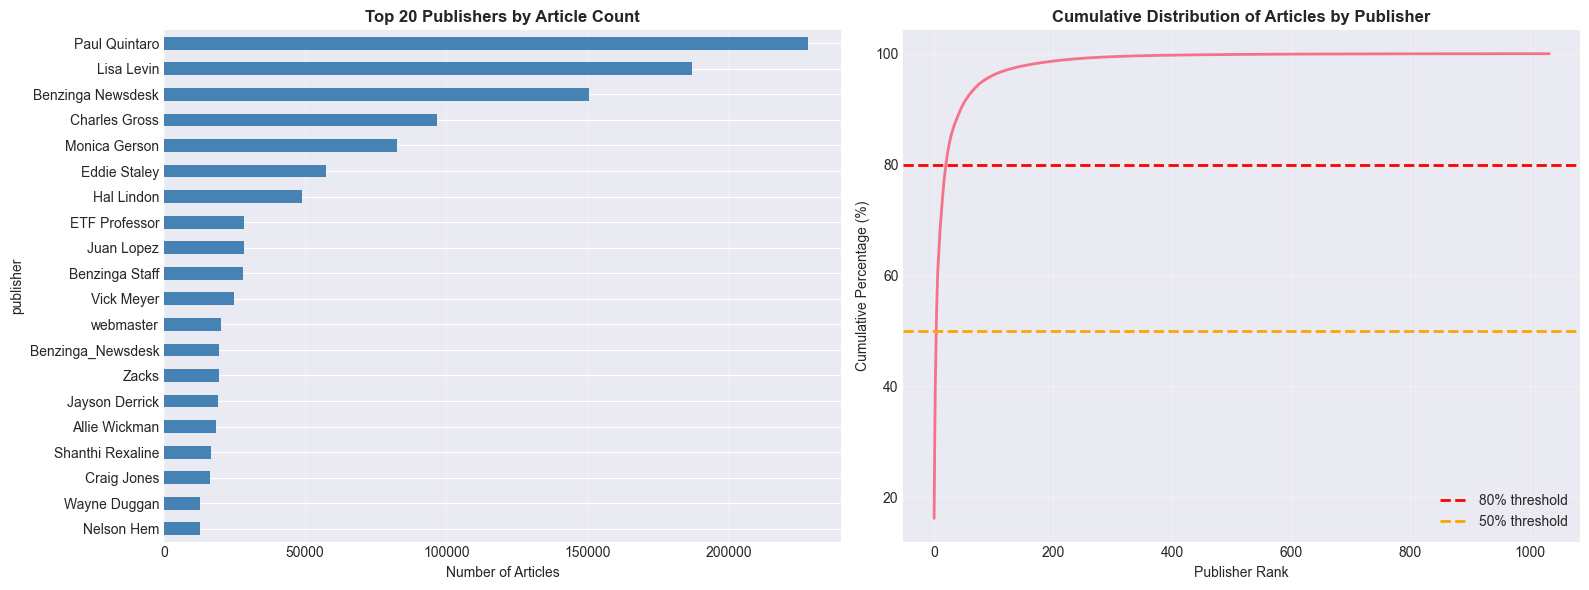

In [15]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of top publishers
top_publishers.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Top 20 Publishers by Article Count', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Articles')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Cumulative distribution
cumulative_pct = (publisher_counts.cumsum() / publisher_counts.sum() * 100)
axes[1].plot(range(len(cumulative_pct)), cumulative_pct, linewidth=2)
axes[1].set_title('Cumulative Distribution of Articles by Publisher', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Publisher Rank')
axes[1].set_ylabel('Cumulative Percentage (%)')
axes[1].axhline(y=80, color='r', linestyle='--', label='80% threshold', linewidth=2)
axes[1].axhline(y=50, color='orange', linestyle='--', label='50% threshold', linewidth=2)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('publisher_activity.png', dpi=300, bbox_inches='tight')
plt.show()


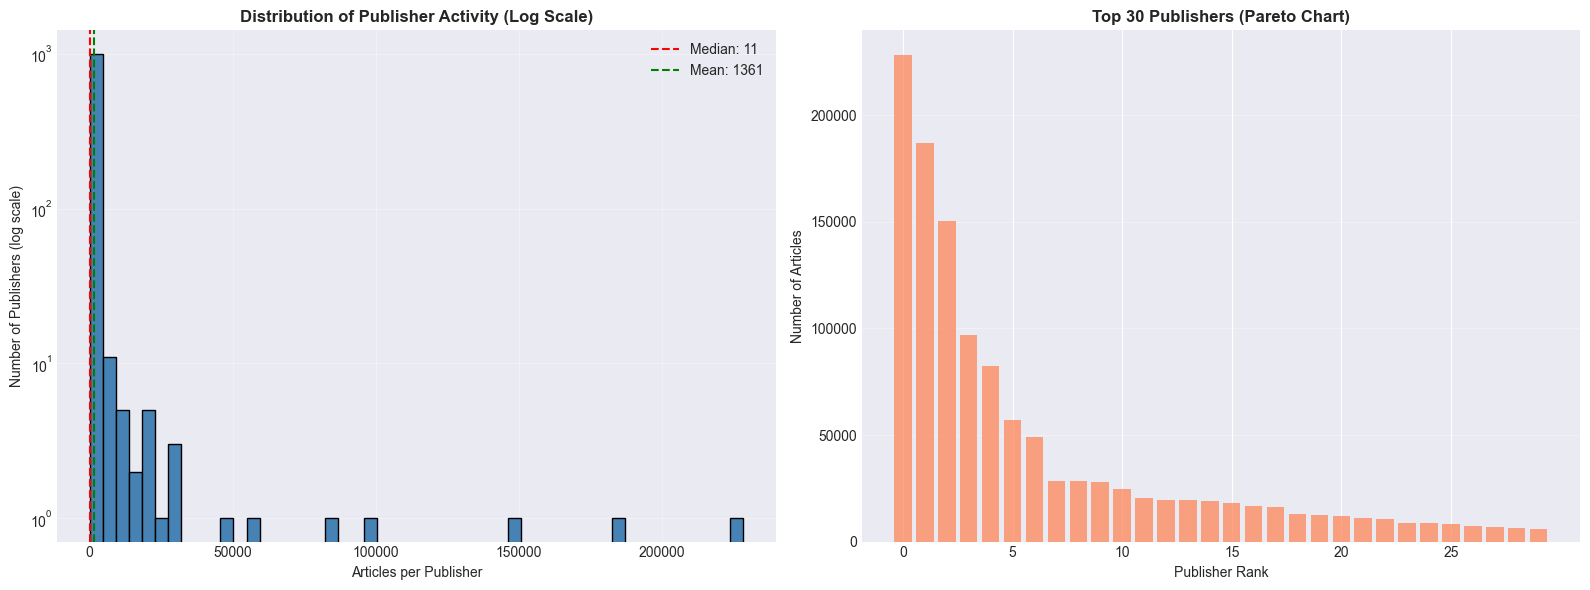

In [16]:
# Long-tail distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution of article counts (log scale)
axes[0].hist(publisher_counts.values, bins=50, edgecolor='black', log=True, color='steelblue')
axes[0].set_xlabel('Articles per Publisher')
axes[0].set_ylabel('Number of Publishers (log scale)')
axes[0].set_title('Distribution of Publisher Activity (Log Scale)', fontsize=12, fontweight='bold')
axes[0].axvline(publisher_counts.median(), color='r', linestyle='--', 
                label=f'Median: {publisher_counts.median():.0f}')
axes[0].axvline(publisher_counts.mean(), color='green', linestyle='--', 
                label=f'Mean: {publisher_counts.mean():.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Pareto chart (top 30 publishers)
top_30 = publisher_counts.head(30)
axes[1].bar(range(len(top_30)), top_30.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Publisher Rank')
axes[1].set_ylabel('Number of Articles')
axes[1].set_title('Top 30 Publishers (Pareto Chart)', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(0, len(top_30), 5))
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('publisher_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## 1.3 Publication Date Trends

**Objective:** Analyze publication dates to identify trends over time and temporal patterns.

**Key Questions:**
- Are there specific days of the week with more news?
- What months or years show increased activity?
- Can you identify specific events that caused publication spikes?


In [17]:
# Ensure date is datetime and extract temporal features
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract temporal features (if not already present)
if 'year' not in df.columns:
    df['year'] = df['date'].dt.year
if 'month' not in df.columns:
    df['month'] = df['date'].dt.month
if 'day_of_week' not in df.columns:
    df['day_of_week'] = df['date'].dt.day_name()
if 'hour' not in df.columns:
    df['hour'] = df['date'].dt.hour
if 'date_only' not in df.columns:
    df['date_only'] = df['date'].dt.date

# Filter out invalid dates for temporal analysis
df_valid_dates = df[df['date'].notna()].copy()

print("="*80)
print("PUBLICATION DATE TRENDS")
print("="*80)
print(f"\nValid dates: {len(df_valid_dates):,} ({len(df_valid_dates)/len(df)*100:.2f}%)")
print(f"Date range: {df_valid_dates['date'].min()} to {df_valid_dates['date'].max()}")


PUBLICATION DATE TRENDS

Valid dates: 55,987 (3.98%)
Date range: 2011-04-27 21:01:48-04:00 to 2020-06-11 17:12:35-04:00


In [22]:
# Articles per year
articles_per_year = df_valid_dates.groupby('year').size()
print("\n" + "="*80)
print("ARTICLES PER YEAR")
print("="*80)
print(articles_per_year)

# Articles per month (across all years)
articles_per_month = df_valid_dates.groupby('month').size()
print("\n" + "="*80)
print("ARTICLES PER MONTH (Aggregated)")
print("="*80)
print(articles_per_month)

# Articles per day of week
articles_per_dow = df_valid_dates.groupby('day_of_week').size()
print("\n" + "="*80)
print("ARTICLES PER DAY OF WEEK")
print("="*80)
print(articles_per_dow)



ARTICLES PER YEAR
year
2011.0      760
2012.0     1187
2013.0     1240
2014.0     1189
2015.0     3695
2016.0     4223
2017.0     3581
2018.0     5395
2019.0     6325
2020.0    28392
dtype: int64

ARTICLES PER MONTH (Aggregated)
month
1.0      3068
2.0      4091
3.0      6391
4.0      6468
5.0     11363
6.0      7968
7.0      2131
8.0      2858
9.0      2417
10.0     3079
11.0     3210
12.0     2943
dtype: int64

ARTICLES PER DAY OF WEEK
day_of_week
Friday        9381
Monday       10322
Saturday       267
Sunday         436
Thursday     12688
Tuesday      11002
Wednesday    11891
dtype: int64


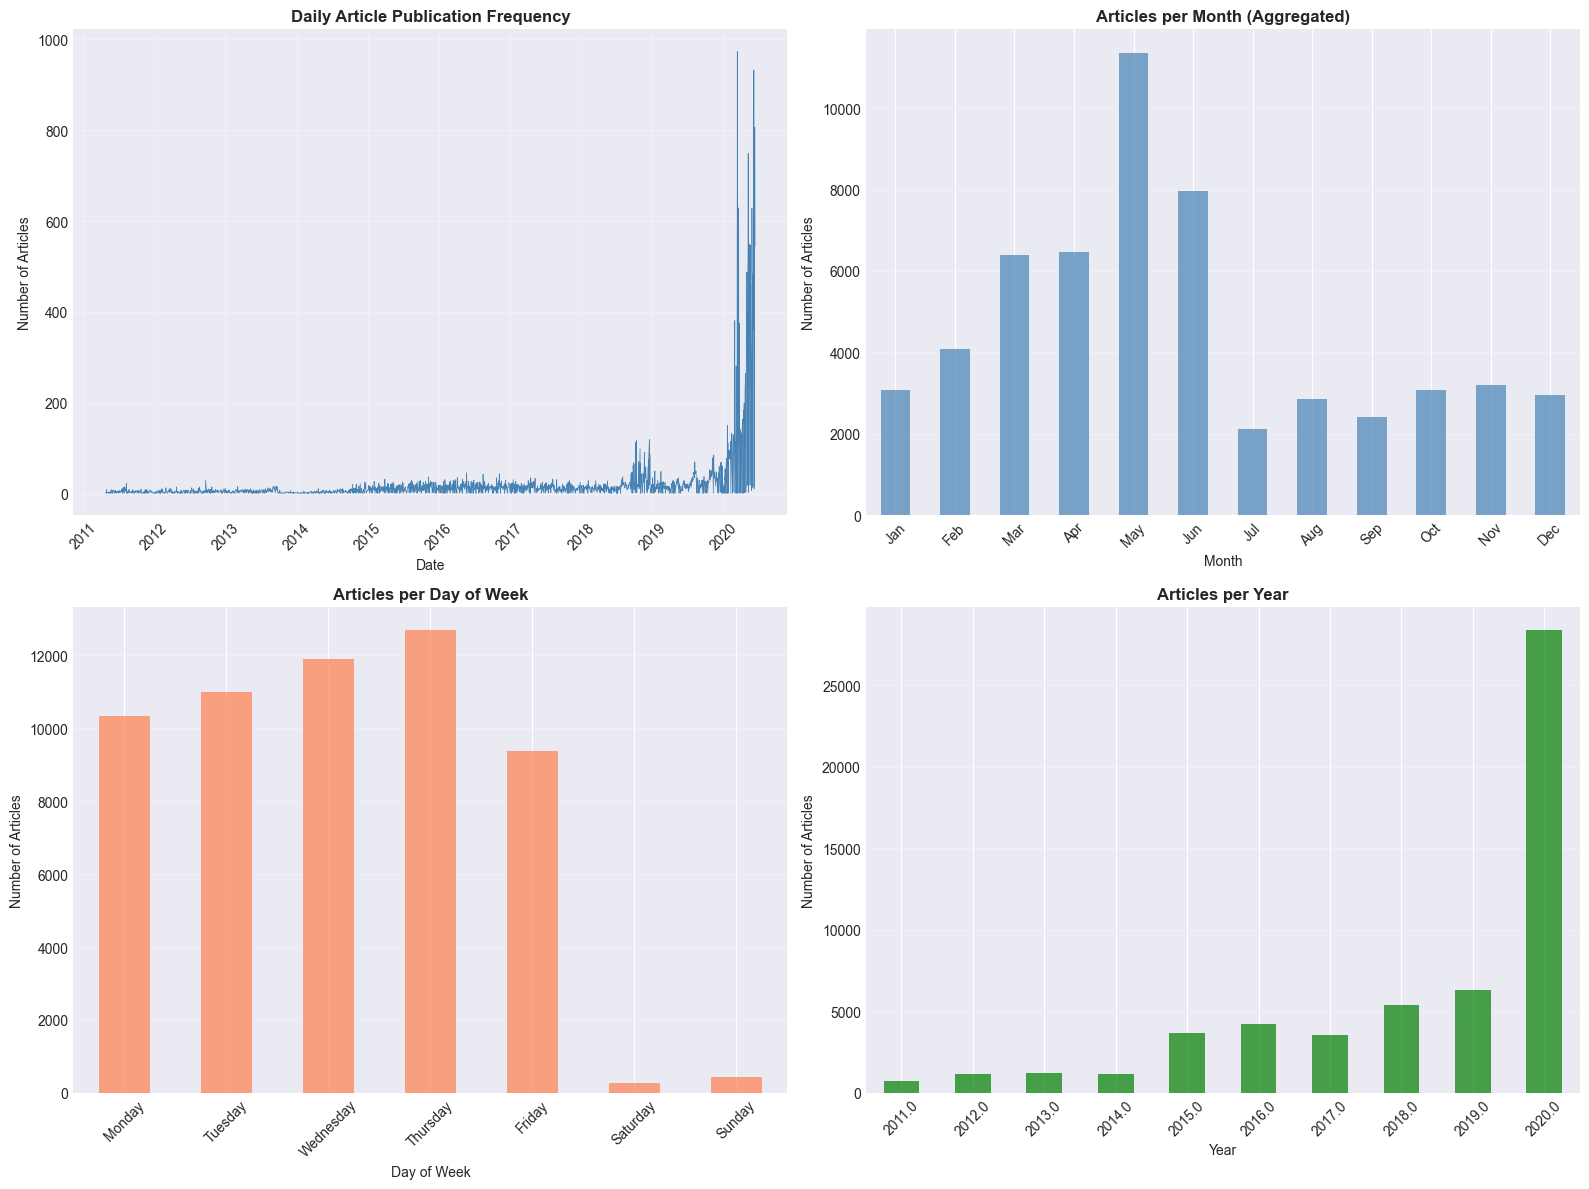

In [23]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Time series: Articles per day
daily_counts = df_valid_dates.groupby('date_only').size()
axes[0, 0].plot(daily_counts.index, daily_counts.values, linewidth=0.5, color='steelblue')
axes[0, 0].set_title('Daily Article Publication Frequency', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Articles')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Articles per month
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
articles_per_month.plot(kind='bar', ax=axes[0, 1], color='steelblue', alpha=0.7)
axes[0, 1].set_title('Articles per Month (Aggregated)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Articles')
axes[0, 1].set_xticklabels(month_labels, rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Articles per day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
articles_per_dow = articles_per_dow.reindex(day_order)
articles_per_dow.plot(kind='bar', ax=axes[1, 0], color='coral', alpha=0.7)
axes[1, 0].set_title('Articles per Day of Week', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Articles')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Articles per year
articles_per_year.plot(kind='bar', ax=axes[1, 1], color='green', alpha=0.7)
axes[1, 1].set_title('Articles per Year', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Articles')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('publication_trends.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
# Identify spikes (days with unusually high article counts)
mean_daily = daily_counts.mean()
std_daily = daily_counts.std()
spike_threshold = mean_daily + 2 * std_daily
spike_days = daily_counts[daily_counts > spike_threshold]

print("="*80)
print("PUBLICATION SPIKES DETECTION")
print("="*80)
print(f"Mean daily articles: {mean_daily:.1f}")
print(f"Standard deviation: {std_daily:.1f}")
print(f"Spike threshold (>2 std dev): {spike_threshold:.1f} articles")
print(f"\nDays with spike in publications (>2 std dev): {len(spike_days):,}")
print("\nTop 10 days with most articles:")
print(spike_days.nlargest(10))


PUBLICATION SPIKES DETECTION
Mean daily articles: 22.1
Standard deviation: 68.1
Spike threshold (>2 std dev): 158.4 articles

Days with spike in publications (>2 std dev): 51

Top 10 days with most articles:
date_only
2020-03-12    973
2020-06-05    932
2020-06-10    806
2020-06-09    804
2020-06-08    765
2020-05-07    749
2020-06-03    720
2020-03-19    629
2020-05-26    628
2020-05-13    549
dtype: int64


## Summary

This notebook has analyzed:

1. **Headline Length Analysis:**
   - Calculated descriptive statistics for character and word counts
   - Identified outliers and distribution patterns
   - Analyzed variation by publisher and stock

2. **Articles Per Publisher:**
   - Identified top contributing publishers
   - Analyzed long-tail distribution
   - Calculated concentration metrics

3. **Publication Date Trends:**
   - Analyzed temporal patterns (yearly, monthly, daily)
   - Identified day-of-week patterns
   - Detected publication spikes

**Next Steps:**
- Proceed to `03_Text_Analysis.ipynb` for NLP and topic modeling
- Or continue with `04_Time_Series_Analysis.ipynb` for deeper temporal analysis
